# Install and load packages as necessary

In [126]:
# Package names
packages<-c("dplyr", "lubridate", "ggplot2", "ggpubr")

# Install packages if necessary
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Load packages
invisible(lapply(packages, library, character.only = TRUE))


Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by




# Locate calibration directories

In [51]:
# HARDCODED directory that contains all the calibration folders
# each calibration folder must contain a file called "calibration_data.csv"
# which is a subset of data points from each calibration run to use
dataDirectory<-"~/Desktop/data/mesoBinTests/"

# Function that concatenates all the calibration_data.csv

In [78]:
concat_calibration<-function(directory=dataDirectory){
    #define custom call to read.csv and remove debug lines & where logger is not populated
    readCSV<-function(filePath){
        fileData<-read.csv(filePath,header=TRUE)
        fileData<-subset(fileData, type!="debug" & !is.na(logger))
    }
    
    # find directories with the word calibration
    calDirs<-list.files(path=directory, recursive=FALSE, pattern="*calibration*", full.names=TRUE)
    
    # affix the correct file name to each folder found
    calFiles<-paste(calDirs,"/calibration_data.csv",sep="")
    
    # check that all those files exist
    if ( all( file.exists(calFiles) ) == FALSE ){
        print("Error: calibration directory missing calibration_data.csv")
        return(NULL)
    } else {
        print("Calibration data found")
    }
    
    #read each file and output a single dataframe
    data<-do.call(rbind, lapply(calFiles,readCSV))
    return(data)
}

In [81]:
calData<-concat_calibration()
str(calData)

[1] "Calibration data found"
'data.frame':	120 obs. of  21 variables:
 $ X               : int  23262 24012 24762 25512 26262 218374 218449 218524 218599 218674 ...
 $ type            : chr  "summary" "summary" "summary" "summary" ...
 $ site            : chr  "C1" "C1" "C1" "C1" ...
 $ logger          : chr  "21010" "21010" "21010" "21010" ...
 $ deployment      : chr  "floatWaterBin-57FF70068387575129270167-1675266374" "floatWaterBin-57FF70068387575129270167-1675266374" "floatWaterBin-57FF70068387575129270167-1675266374" "floatWaterBin-57FF70068387575129270167-1675266374" ...
 $ deployed_at     : int  1675266374 1675266374 1675266374 1675266374 1675266374 1675179576 1675179576 1675179576 1675179576 1675179576 ...
 $ uuid            : chr  "57FF70068387575129270167" "57FF70068387575129270167" "57FF70068387575129270167" "57FF70068387575129270167" ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : chr  "2023-02-02 16:30:27" "2023-02-02 16

# Function to process column types

In [82]:
process_columns<-function(df){
    df$type<-as.factor(df$type)
    df$site<-as.factor(df$site)
    df$logger<-as.factor(df$logger)
    df$deployment<-as.factor(df$deployment)
    df$deployed_at<-as.integer(df$deployed_at)
    df$uuid<-as.factor(df$uuid)
    df$time.s<-as.numeric(df$time.s)
    df$time.h<-lubridate::as_datetime(df$time.h)
    
    cols<-names(df)
    if("measurementCycle" %in% cols & "burstCycle" %in% cols){
        df$measurementCycle<-as.numeric(df$measurementCycle)
        df$burstCycle<-as.factor(df$burstCycle)
    }
    
    ##hardcoded, but could be all columns between time.h and user_note? or measurementCycle when included
    df$battery.V<-as.numeric(df$battery.V)
    df$dht_C<-as.numeric(df$dht_C)
    df$dht_RH<-as.numeric(df$dht_RH)
    
    if("atlas_CO2_ppm" %in% cols){
        df$atlas_CO2_ppm<-as.numeric(df$atlas_CO2_ppm)
    }
    
    df$ch4rf_raw<-as.numeric(df$ch4rf_raw)
    df$ch4rf_cal<-as.numeric(df$ch4rf_cal)
    df$ch4_raw<-as.numeric(df$ch4_raw)
    df$ch4_cal<-as.numeric(df$ch4_cal)
    
    return(df)
}

In [87]:
calData<-process_columns(calData)
str(calData)

'data.frame':	120 obs. of  21 variables:
 $ X               : int  23262 24012 24762 25512 26262 218374 218449 218524 218599 218674 ...
 $ type            : Factor w/ 1 level "summary": 1 1 1 1 1 1 1 1 1 1 ...
 $ site            : Factor w/ 6 levels "C1","C2","C3",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ logger          : Factor w/ 6 levels "21001","21010",..: 2 2 2 2 2 3 3 3 3 3 ...
 $ deployment      : Factor w/ 6 levels "floatWaterBin-50FF6C068678545210222467-1675179416",..: 5 5 5 5 5 3 3 3 3 3 ...
 $ deployed_at     : int  1675266374 1675266374 1675266374 1675266374 1675266374 1675179576 1675179576 1675179576 1675179576 1675179576 ...
 $ uuid            : Factor w/ 6 levels "50FF6C068678545210222467",..: 5 5 5 5 5 3 3 3 3 3 ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : POSIXct, format: "2023-02-02 16:30:27" "2023-02-02 16:31:27" ...
 $ battery.V       : num  1343 1347 1347 1351 1350 ...
 $ measurementCycle: num  9 9 9 9 9 ...
 $ burstCycl

# Function to average data for each sensor/site and measurement cycle

In [137]:
names(calData)

[1] "X"                "type"             "site"             "logger"          
 [5] "deployment"       "deployed_at"      "uuid"             "time.s"          
 [9] "time.h"           "battery.V"        "measurementCycle" "burstCycle"      
[13] "dht_C"            "dht_RH"           "ch4rf_raw"        "ch4rf_cal"       
[17] "ch4_raw"          "ch4_cal"          "user_note"        "user_value"      
[21] "ch4_ppm"

In [155]:
average_runs<-function(df){
    grouped <- group_by(df, site, measurementCycle)
    means <- summarise(grouped,
                       type=type,
                       site=site,
                       deployment=deployment,
                       deployed_at=deployed_at,
                       uuid=uuid,
                       time.s=mean(time.s),
                       time.h=mean(time.h),
                       battery.V=mean(battery.V),
                       ch4rf_raw=mean(ch4rf_raw),
                       ch4rf_cal=mean(ch4rf_cal),
                       ch4_raw=mean(ch4_raw),
                       ch4_cal=mean(ch4_cal),
                       dht_C=mean(dht_C),
                       dht_RH=mean(dht_RH),
                       ch4_ppm=mean(ch4_ppm)
                      )
    return(means)
}

In [158]:
calMeans<-average_runs(calData)
calMeans

`summarise()` has grouped output by 'site', 'measurementCycle'. You can override using the `.groups` argument.



site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,dht_C,dht_RH,ch4_ppm
<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,0,833.32,0,10.55,13.95,1.980556
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,0,833.32,0,10.55,13.95,1.980556
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,0,833.32,0,10.55,13.95,1.980556
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,0,833.32,0,10.55,13.95,1.980556


# some basic hardcoded plots

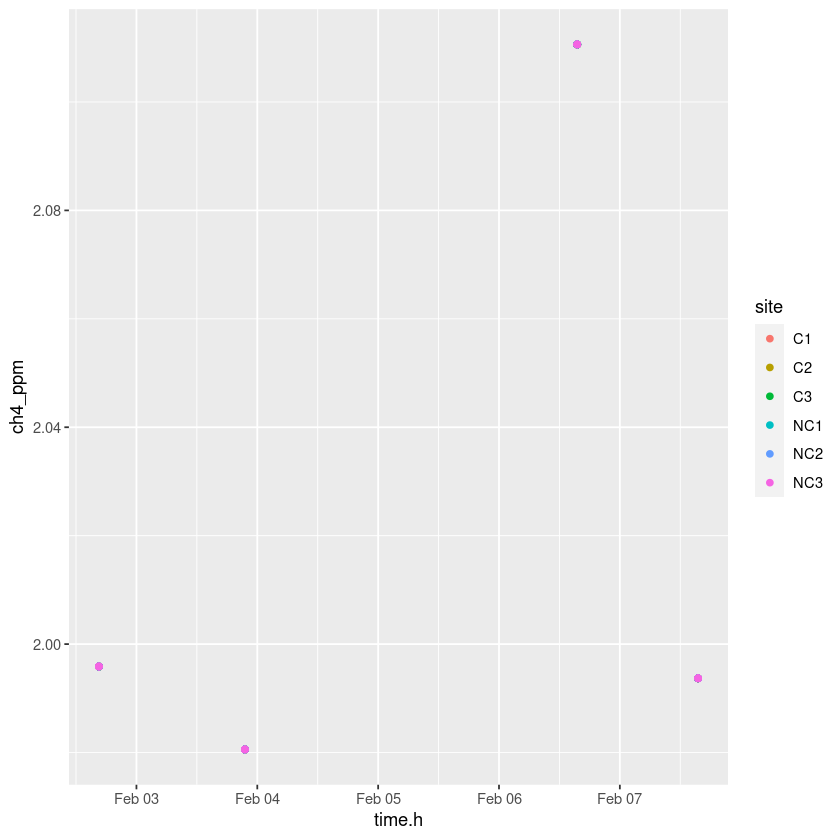

In [172]:
# gas analyzer
ggplot(calMeans,aes(x=time.h,y=ch4_ppm,color=site))+geom_point()

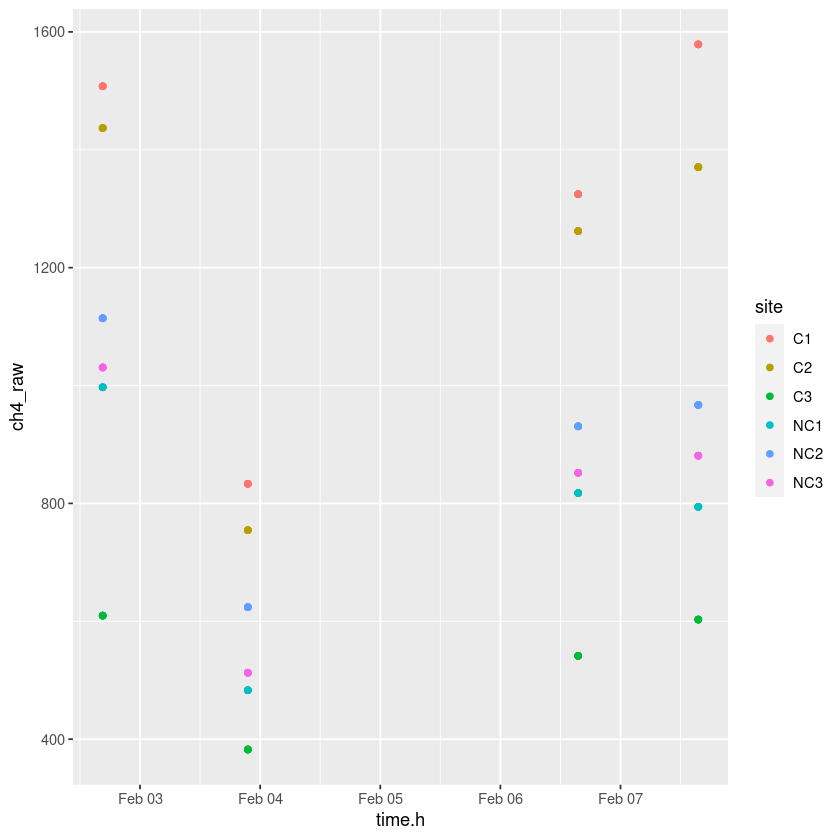

In [171]:
ggplot(calMeans,aes(x=time.h,y=ch4_raw,color=site))+geom_point()

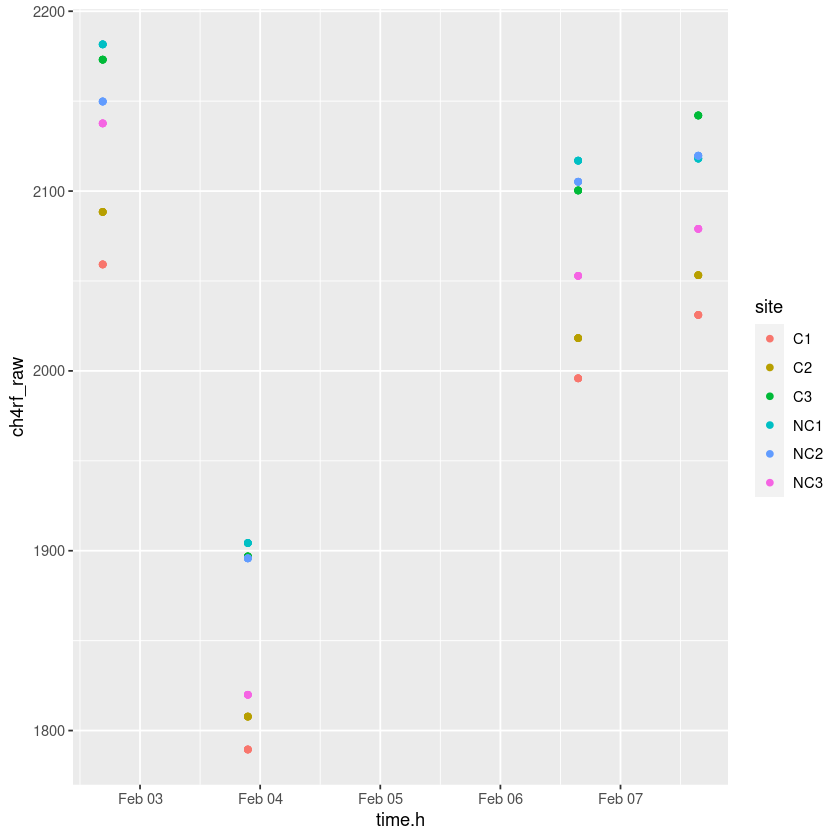

In [162]:
ggplot(calMeans,aes(x=time.h,y=ch4rf_raw,color=site))+geom_point()

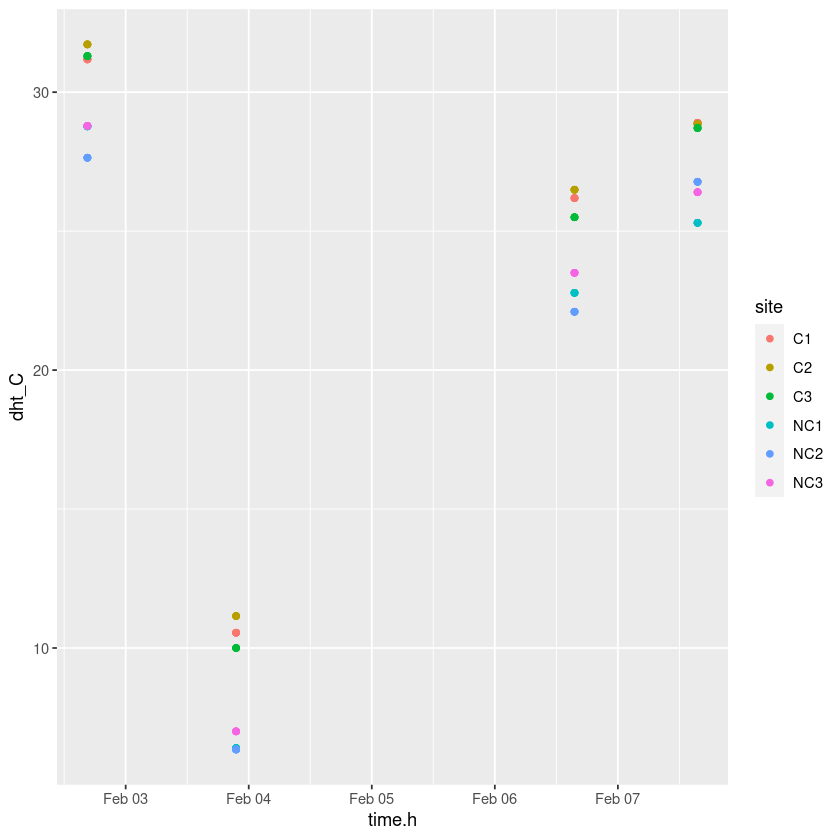

In [163]:
ggplot(calMeans,aes(x=time.h,y=dht_C,color=site))+geom_point()

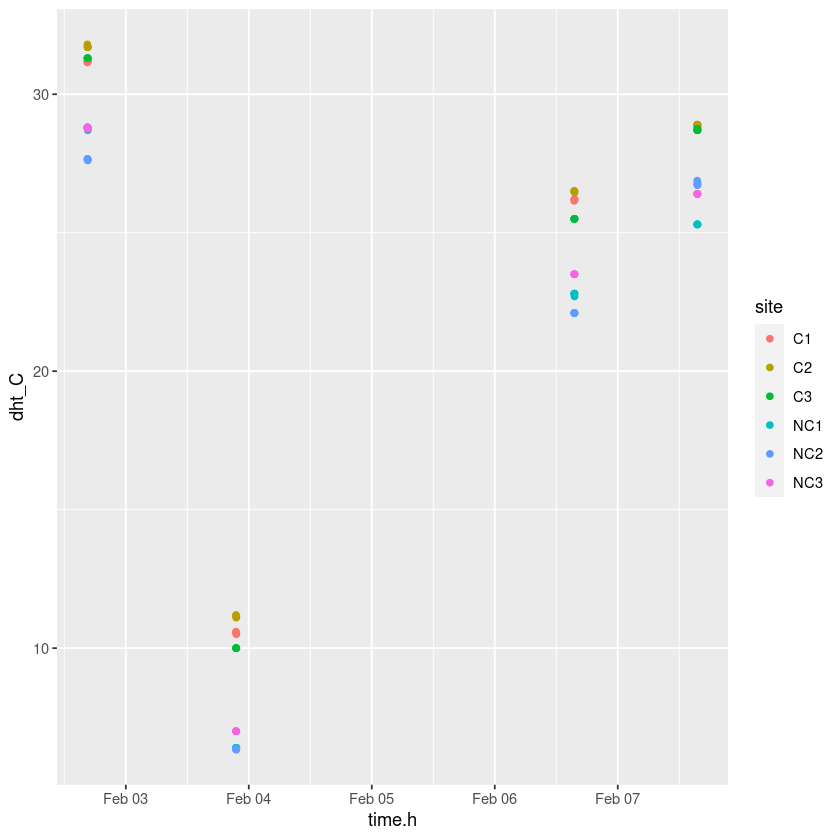

In [173]:
ggplot(calData,aes(x=time.h,y=dht_C,color=site))+geom_point()

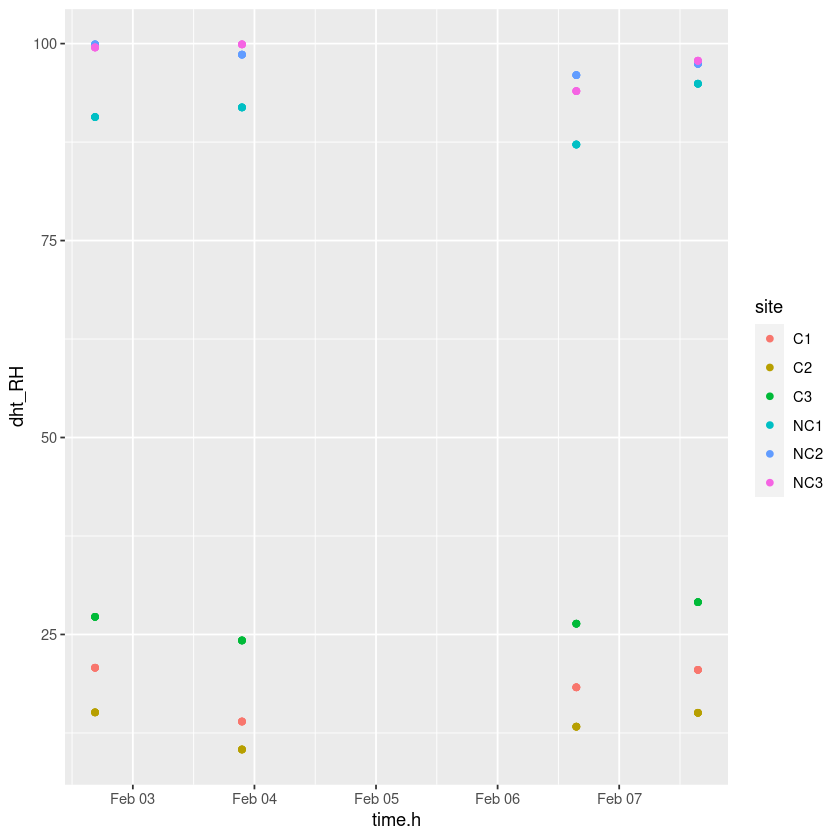

In [164]:
ggplot(calMeans,aes(x=time.h,y=dht_RH,color=site))+geom_point()

In [165]:
encasedData<-calMeans[calMeans$site==c("C1","C2","C3"),]
noCaseData<-calMeans[calMeans$site==c("NC1","NC2","NC3"),]

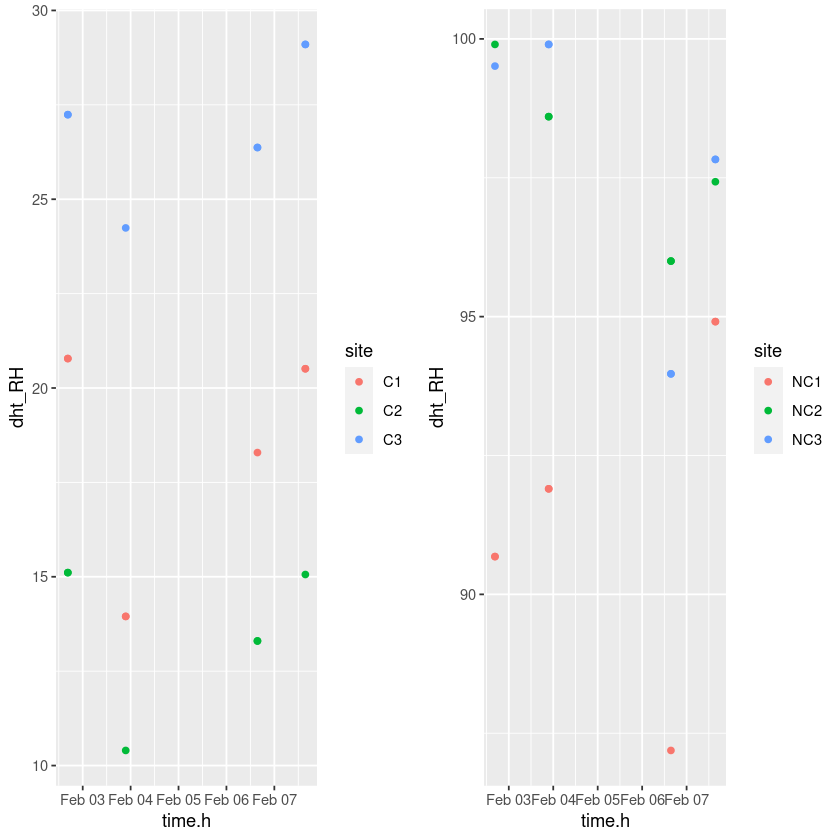

In [166]:
a<-ggplot(encasedData,aes(x=time.h,y=dht_RH,color=site))+geom_point()
b<-ggplot(noCaseData,aes(x=time.h,y=dht_RH,color=site))+geom_point()

ggarrange(a,b)

# math

In [174]:
df<-calMeans
df$dht_K<-df$dht_C+273.15

#determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
P<-1013.25 #millibar, standard pressure ~1 atmosphere
df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
df$ews_kPa<-df$ews_mbar/10

# # function to lookup pressure at temperatures(https://www.nist.gov/system/files/documents/srd/NISTIR5078-Tab1.pdf)
# # digitized version provided by University of Colorado Boulder (https://learncheme.com/student-resources/steam-tables/)
# steamTablePath<-"~/Desktop/data/mesoBinTests/saturated_by_temperature_V1.4.csv"
# steamTable<-read.csv(steamTablePath, skip=6, header=TRUE)
# # TODO: need to round 0 C or below to 0.01 C, interpolate for values in between table values?
# steamTableLookup<-function(temperature_C){
#     return(as.numeric(steamTable[steamTable[1]==temperature_C,][2]*1000)) # 1MPa=1000kPa
# }
# df$PH2O_kPa<-lapply(round(df$dht_C),steamTableLookup)
# df$PH2O_kPa<-as.numeric(df$PH2O_kPa)
# # df[c("dht_C","PH2O_kPa")]

#convert relative humidity to molar PPM (https://www.learnthermo.com/examples/ch02/p-2d-9.php)
# note: assuming 1 atmosphere, 101.325 kPa, and volume of 1
# df$H2O_mol<-df$dht_RH*df$PH2O_kPa/101.325

df$H2O_mol<-df$dht_RH*df$ews_kPa/101.325
df$BDA_mol<-1-df$H2O_mol #mass of dry air

MW_H2O<-18.01528
MW_BDA<-28.97

df$MW_gas<-df$BDA_mol*MW_BDA+df$H2O_mol*MW_H2O


#vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
C<-2.16679 #gK/J
# df$aH_gm3<-C*df$PH2O_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)

df

site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,ch4rf_raw,⋯,dht_C,dht_RH,ch4_ppm,dht_K,ews_mbar,ews_kPa,H2O_mol,BDA_mol,MW_gas,aH_gm3
<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.904370,3.7904370,0.77735288,0.2226471,20.45432,5.6079855
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.904370,3.7904370,0.77735288,0.2226471,20.45432,5.6079855
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.904370,3.7904370,0.77735288,0.2226471,20.45432,5.6079855
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.904370,3.7904370,0.77735288,0.2226471,20.45432,5.6079855
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.904370,3.7904370,0.77735288,0.2226471,20.45432,5.6079855
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,⋯,10.55,13.95,1.980556,283.70,3.794393,0.3794393,0.05223961,0.9477604,28.39773,0.4042723
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,⋯,10.55,13.95,1.980556,283.70,3.794393,0.3794393,0.05223961,0.9477604,28.39773,0.4042723
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,⋯,10.55,13.95,1.980556,283.70,3.794393,0.3794393,0.05223961,0.9477604,28.39773,0.4042723
C1,18695,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675459947,2023-02-03 21:32:27,1077.2,1789.48,⋯,10.55,13.95,1.980556,283.70,3.794393,0.3794393,0.05223961,0.9477604,28.39773,0.4042723
